In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from allenAnalysis.utils import *

%matplotlib ipympl

In [2]:
from allenAnalysis.icsd import StandardCSD

In [3]:
import matplotlib

font = {'size'   : 24}

matplotlib.rc('font', **font)

In [4]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [5]:
typesL = np.load('EEGs.npy',allow_pickle=True).item()
totalL = np.load('total.npy')[:,:52]

In [6]:
objective = np.load('total.npy')[:,52:]


In [7]:
import h5py
f = h5py.File('/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/newCoeffs/b3122c45-e2d9-4205-821c-88f28791dc69/0/neuropixels/coeffsneuropixels.h5')


In [8]:
electrodePos = []
for e in np.arange(51):
    electrodePos.append(f['electrodes']['Neuropixels-384_'+str(e)]['location'][:])
    
electrodePos = np.array(electrodePos)

In [9]:
layers = []

for i in range(51):
    
    l = str(f['electrodes']['Neuropixels-384_'+str(i)]['layer'][()])
    
    if l == "b'Outside'":
        
        layers.append('Outside')
        
    else:
    
        l = l.split('L')[-1]

        layers.append(int(l[0]))

In [10]:
f.close()

In [11]:
breaks = np.where(np.diff(layers)!=0)[0]

In [12]:
breaks

array([17, 29, 34, 43, 46])

In [13]:
meanLfp = np.mean(totalL,axis=0)

In [14]:
totalL -= meanLfp

In [15]:
import bluepysnap as bp
s = bp.Simulation('0/simulation_config.json')
types = np.sort(list(s.circuit.nodes.property_values('mtype')))

In [16]:
byLayer = {}

for layer in np.arange(1,7):
    
    
    for i, t in enumerate(types):

        if str(layer) in t:

            try:
                byLayer[layer] += typesL[t][:,:52]-np.mean(typesL[t][:,:52],axis=0)
            except:
                byLayer[layer] = typesL[t][:,:52]-np.mean(typesL[t][:,:52],axis=0)
                

In [17]:
byLayerObjective = {}

for layer in np.arange(1,7):
    
    
    for i, t in enumerate(types):

        if str(layer) in t:

            try:
                byLayerObjective[layer] += typesL[t][:,52:]-np.mean(typesL[t][:,52:],axis=0)
            except:
                byLayerObjective[layer] = typesL[t][:,52:]-np.mean(typesL[t][:,52:],axis=0)

In [18]:
time = np.arange(0,3000,1)

In [19]:
len(time)

3000

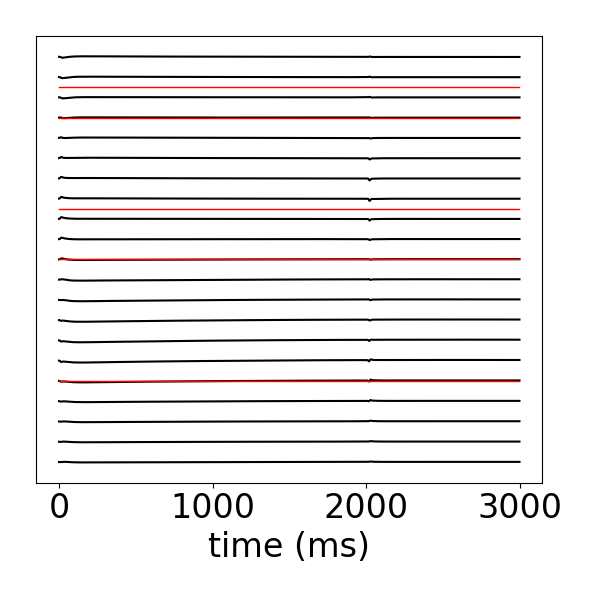

In [20]:
plt.figure(figsize=(6,6))

for i in np.arange(9,51,2):
    plt.plot(time, totalL[:,i]+i*1e-2,c='k')
    
for b in breaks:
    plt.plot([time[0],time[-1]],[b*1e-2,b*1e-2],c='r',linewidth=1)
    
plt.xlabel('time (ms)')
plt.yticks([])

plt.tight_layout()

In [21]:
totalL.shape

(3000, 52)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


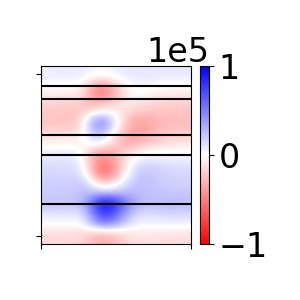

In [30]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

fig, axes = plt.subplots(1,1,figsize=(3,3))

lfp_data = objective[:,9:-1:4].T * 1E-3 * pq.V        # [mV] -> [V]


z_data = np.arange(9,51,3) * 1e-6 * pq.m
#z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
diam = 500E-6 * pq.m                              # [m]
h = 1E-6 * pq.m                                 # [m]
sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

# Input dictionaries for each method

std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}
#Create the different CSD-method class instances. We use the class methods
#get_csd() and filter_csd() below to get the raw and spatially filtered
#versions of the current-source density estimates.
csd_dict = dict(
#     delta_icsd = DeltaiCSD(**delta_input),
#     step_icsd = StepiCSD(**step_input),
#     spline_icsd = SplineiCSD(**spline_input),
    std_csd = StandardCSD(**std_input),
)

for method, csd_obj in csd_dict.items():
    
    
    
    ax = axes
        
#     for b in breaks-9:
#         ax.plot([0,30000],[b/4,b/4],c='k')

    
#     #plot LFP signal
    


#     im = ax.imshow(np.array(lfp_data), origin='lower', vmin=-abs(lfp_data).max(), \
#           vmax=abs(lfp_data).max(), cmap='bwr_r', interpolation='gaussian')
#     ax.axis(ax.axis('tight'))
#     cb = plt.colorbar(im, ax=ax)
#     cb.formatter.set_powerlimits((0, 0))
#     cb.set_label('LFP (%s)' % lfp_data.dimensionality.string)
#     ax.set_xticklabels([])
# #     ax.set_yticklabels([])
#     ax.set_title('LFP')
#     ax.set_ylabel('ch #')


    #plot raw csd estimate
    csd = csd_obj.get_csd()

    ax.set_xlim([20000,20500])
    # ax = axes[1]
    
    for b in breaks-9:
        ax.plot([0,30000],[b/4,b/4],c='k')


    csd = csd_obj.filter_csd(csd)
    im = ax.imshow(np.array(csd), origin='lower', vmin=-1e5, \
          vmax=1e5, cmap='bwr_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))
    # ax.set_title('CSD')
    cb = plt.colorbar(im, ax=ax)

    # cb.set_label('CSD (%s)' % csd.dimensionality.string)
#     ax.set_ylabel('ch #')

    ax.set_yticklabels([])
    ax.set_xticklabels([])
# 
    ax.set_xlim([2000,2050])

    cb.formatter.set_powerlimits((0,0))



plt.tight_layout()
plt.show()




/gpfs/bbp.cscs.ch/home/tharayil/allen/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


/gpfs/bbp.cscs.ch/home/tharayil/allen/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


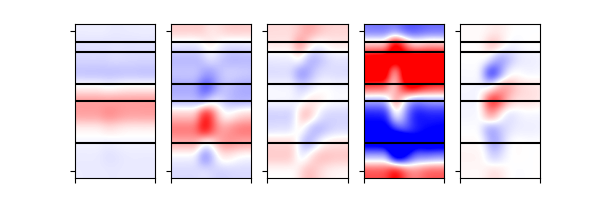

In [32]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

fig, axes = plt.subplots(1,5,figsize=(6,2))

for i in np.arange(2,7):

    lfp_data = byLayerObjective[i][:,9:-1:4].T * 1E-3 * pq.V        # [mV] -> [V]

    z_data = np.arange(51) * 1e-6 * pq.m
    #z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
    diam = 500E-6 * pq.m                              # [m]
    h = 1E-6 * pq.m                                 # [m]
    sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
    sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

    # Input dictionaries for each method

    std_input = {
        'lfp' : lfp_data,
        'coord_electrode' : z_data,
        'sigma' : sigma,
        'f_type' : 'gaussian',
        'f_order' : (3, 1),
    }
    #Create the different CSD-method class instances. We use the class methods
    #get_csd() and filter_csd() below to get the raw and spatially filtered
    #versions of the current-source density estimates.
    csd_dict = dict(
        std_csd = StandardCSD(**std_input),
    )

    for method, csd_obj in csd_dict.items():


    #     #plot LFP signal
    #     ax = axes[0][i-2]
        
    #     for b in breaks:
    #         ax.plot([0,30000],[b,b],c='k')


    #     im = ax.imshow(np.array(lfp_data), origin='lower', vmin=-2.5e-5, \
    #               vmax=2.5e-5, cmap='jet_r', interpolation='gaussian')
    #     ax.axis(ax.axis('tight'))
    #     #cb = plt.colorbar(im, ax=ax)
    #     #cb.set_label('LFP (%s)' % lfp_data.dimensionality.string)
    #     ax.set_xticklabels([])
    #     ax.set_yticklabels([])
    #     ax.set_xlim([20000,20500])
    #     #     ax.set_title('LFP')
    # #         ax.set_ylabel('ch #')


        #plot raw csd estimate
        csd = csd_obj.get_csd()


        ax = axes[i-2]
        
        for b in breaks-9:
            ax.plot([0,30000],[b/4,b/4],c='k')


        csd = csd_obj.filter_csd(csd)
        im = ax.imshow(np.array(csd), origin='lower', vmin=-1e5, \
              vmax=1e5, cmap='bwr_r', interpolation='gaussian')
        ax.axis(ax.axis('tight'))
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim([2000,2050])
        #     ax.set_title('CSD')
       # cb = plt.colorbar(im, ax=ax)

       # cb.set_label('CSD (%s)' % csd.dimensionality.string)
    #         ax.set_ylabel('ch #')


        # cb.formatter.set_powerlimits((0,0))



    # plt.tight_layout()
    # plt.show()



In [28]:
sinks_objective = np.zeros_like(lfp_data)
sources_objective = np.zeros_like(lfp_data)
mask_sinks_objective = lfp_data<0
mask_sources_objective = lfp_data > 0

sinks_objective[mask_sinks_objective] = np.abs(lfp_data[mask_sinks_objective])
sources_objective[mask_sources_objective] = np.abs(lfp_data[mask_sources_objective])

sinks_objective /= sinks_objective.sum()
sources_objective /= sources_objective.sum()

In [29]:
sinks = np.zeros_like(csd)
sources = np.zeros_like(csd)
mask_sinks = csd<0
mask_sources = csd > 0

sinks[mask_sinks] = np.abs(csd[mask_sinks])
sources[mask_sources] = np.abs(csd[mask_sources])

sinks /= sinks.sum()
sources /= sources.sum()

In [30]:
sink_matrix_recon_exp, M_sink_recon_exp, G0_sink_recon_exp, x_s, x_t = compute_dist_matrix_exp([sinks], 
                                                                             [sinks_objective],
                                                                            mode = 'exp_to_reco')


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]/gpfs/bbp.cscs.ch/home/tharayil/allen/lib/python3.11/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:10<00:00, 70.83s/it]


In [31]:
source_matrix_recon_exp, M_source_recon_exp, G0_source_recon_exp, x_s, x_t = compute_dist_matrix_exp([sources], 
                                                                             [sources_objective],
                                                                            mode = 'exp_to_reco')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:16<00:00, 76.50s/it]


In [32]:
dist_matrix_recon_exp = sink_matrix_recon_exp+source_matrix_recon_exp

In [33]:
dist_matrix_recon_exp

array([[0.00375828]])

In [ ]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(lfp_data)

In [ ]:
pca.components_.shape

In [ ]:
recon = np.empty((4, sp_len, t_len))
for compNr in range(4):
    recon[compNr] = np.dot(pca.components_[compNr], lfp_data).reshape(sp_len, t_len)*\
                        pca.explained_variance_ratio_[compNr]

In [ ]:
recon_sinks_list = np.empty_like(recon)
recon_sources_list = np.empty_like(recon)

for compNr in range(recon.shape[0]):
    recon_temp = recon[compNr]
    mask_sinks = recon_temp < 0
    mask_sources = recon_temp > 0
    
    sinks_recon_temp = np.zeros_like(recon_temp)
    sinks_recon_temp[mask_sinks] = np.abs(recon_temp[mask_sinks])
    sources_recon_temp = np.zeros_like(recon_temp)
    sources_recon_temp[mask_sources] = np.abs(recon_temp[mask_sources])
    
    recon_sinks_list[compNr] = sinks_recon_temp/sinks_recon_temp.sum()
    recon_sources_list[compNr] = sources_recon_temp/sources_recon_temp.sum()